In [11]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Dense 
print('TensorFlow',tf.__version__)

TensorFlow 2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.6 GB  | Proc size: 376.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Loading the dataset using tensorflow_datasets 

In [0]:
NUM_SAMPLES = 400000
dataset = tfds.load(name='wmt14_translate/fr-en', as_supervised=True, download=False, data_dir="/content/drive/My Drive")
dataset['train'] = dataset['train'].take(NUM_SAMPLES)

## Adding start and end sequence markers

In [6]:
en_sentences = []
fr_sentences = []
for example in tqdm(dataset['train']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')
for example in tqdm(dataset['validation']):
    en_sentences.append(example[0].numpy().decode())
    fr_sentences.append('startseq ' + example[1].numpy().decode() + ' endseq')    

400000it [02:29, 2666.98it/s]
3000it [00:02, 1427.00it/s]


## Tokenization

In [0]:
en_tk = Tokenizer(num_words=30000)
fr_tk = Tokenizer(num_words=30000)

with open('en.pkl', 'wb') as f:
    pickle.dump(en_tk, f)

with open('fr.pkl', 'wb') as f:
    pickle.dump(fr_tk, f)
    
en_tk.fit_on_texts(en_sentences)
fr_tk.fit_on_texts(fr_sentences)    

In [0]:
# with open('en.pkl', 'rb') as f:
#     en_tk = pickle.load( f)

# with open('fr.pkl', 'rb') as f:
#     fr_tk = pickle.load(f)

## Visualizing sequence lenghts

English sentences : mean = 28.52640446650124, std = 26.045968383940934, max = 5649
French sentences : mean = 26.91360794044665, std = 21.01531582420789, max = 1505


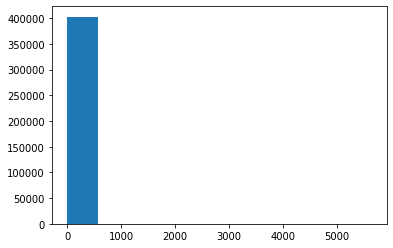

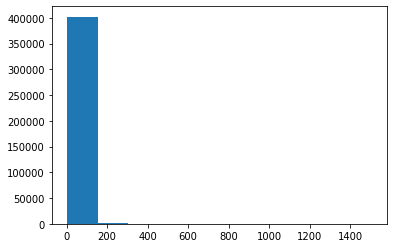

In [8]:
en_lens = [len(x.split()) for x in en_sentences]
fr_lens = [len(x.split()) for x in fr_sentences]

plt.figure()
plt.hist(en_lens)

plt.figure()
plt.hist(fr_lens)

en_mean = np.mean(en_lens)
en_std = np.std(en_lens)
fr_mean = np.mean(fr_lens)
fr_std = np.std(fr_lens)
en_max = np.max(en_lens)
fr_max = np.max(fr_lens)

print(f'English sentences : mean = {en_mean}, std = {en_std}, max = {en_max}')
print(f'French sentences : mean = {fr_mean}, std = {fr_std}, max = {fr_max}')

In [0]:
max_sequence_len = 30
en_vocab_size = 30000
fr_vocab_size = 30000

## Tokenization and sequence padding

In [0]:
def preprocess_en(en):
    encoded_en = en_tk.texts_to_sequences(en)
    padded_en = pad_sequences(encoded_en, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_en

def preprocess_fr(fr):
    encoded_fr = fr_tk.texts_to_sequences(fr)
    padded_fr = pad_sequences(encoded_fr, maxlen=max_sequence_len, padding='post', truncating='post')
    return padded_fr

def preprocess_text(en, fr):
    return preprocess_en(en.numpy().decode()), preprocess_fr(fr.numpy().decode())

## Preparing training dataset

In [11]:
train_ds = dataset['train']
train_en = []
train_fr = []
for example in tqdm(train_ds):
    train_en.append(example[0].numpy().decode())
    train_fr.append('startseq ' + example[1].numpy().decode() + ' endseq')
train_en = preprocess_en(train_en)
train_fr = preprocess_fr(train_fr)

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_en, train_fr))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

400000it [02:15, 2960.39it/s]


## Defininf Encoder, Decoder and Attention models using tf.keras model subclassing

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_size=1024, max_sequence_len=30, batch_size=batch_size, embedding_dim=256, vocab_size=30000):
        super(Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU_1 = GRU(units=hidden_size, return_sequences=True)
        self.GRU_2 = GRU(units=hidden_size,
                         return_sequences=True, return_state=True)

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, initial_state, training=False):
        x = self.embedding_layer(x)
        x = self.GRU_1(x, initial_state=initial_state)
        x, hidden_state = self.GRU_2(x)
        return x, hidden_state


class Attention(tf.keras.Model):
    def __init__(self, hidden_size=256):
        super(Attention, self).__init__()
        self.fc1 = Dense(units=hidden_size)
        self.fc2 = Dense(units=hidden_size)
        self.fc3 = Dense(units=1)

    def call(self, encoder_output, hidden_state, training=False):
        '''hidden_state : h(t-1)'''
        y_hidden_state = tf.expand_dims(hidden_state, axis=1)
        y_hidden_state = self.fc1(y_hidden_state)
        y_enc_out = self.fc2(encoder_output)

        y = tf.keras.backend.tanh(y_enc_out + y_hidden_state)
        attention_score = self.fc3(y)
        attention_weights = tf.keras.backend.softmax(attention_score, axis=1)

        context_vector = tf.multiply(encoder_output, attention_weights)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, hidden_size=1024, max_sequence_len=30, batch_size=batch_size, embedding_dim=256, vocab_size=30000):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sequence_len = max_sequence_len
        self.hidden_size = hidden_size
        self.batch_size = batch_size
    
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size, output_dim=self.embedding_dim)
        self.GRU = GRU(units=hidden_size,
                       return_sequences=True, return_state=True)
        self.attention = Attention(hidden_size=self.hidden_size)
        self.fc = Dense(units=self.vocab_size)

    def initial_hidden_state(self):
        return tf.zeros(shape=(self.batch_size, self.hidden_size))

    def call(self, x, encoder_output, hidden_state, training=False):
        x = self.embedding_layer(x)
        context_vector, attention_weights = self.attention(
            encoder_output, hidden_state, training=training)
        contect_vector = tf.expand_dims(context_vector, axis=1)
        x = tf.concat([x, contect_vector], axis=-1)
        x, curr_hidden_state = self.GRU(x)
        x = tf.reshape(x, shape=[self.batch_size, -1])
        x = self.fc(x)
        return x, curr_hidden_state, attention_weights

## Defining training loop, loss function and optimizer

In [0]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
train_accuracy = tf.metrics.SparseCategoricalAccuracy()


def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    mask = 1 - tf.cast(tf.equal(y_true, 0), 'float32')
    return tf.reduce_mean(loss * mask)
    
@tf.function()
def training_step(en, fr):    
    with tf.GradientTape() as Tape:
        encoder_init_state = encoder.initial_hidden_state()
        encoder_output, encoder_hidden_state = encoder(en, encoder_init_state, training=True)
        decoder_hidden = encoder_hidden_state
        loss = 0
        acc = []
        current_word = tf.expand_dims(fr[:, 0], axis=1)
        for word_idx in range(1, max_sequence_len):
            next_word = fr[:, word_idx]
            logits, decoder_hidden, attention_weights = decoder(current_word, encoder_output, decoder_hidden, training=True)
            loss += loss_function(next_word, logits)
            acc.append(train_accuracy(next_word, logits))
            current_word = tf.expand_dims(next_word, axis=1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = Tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss, tf.reduce_mean(acc)

In [0]:
encoder = Encoder()
decoder = Decoder()
checkpoint_dir = '/content/drive/My Drive/training400000'
checkpoint_prefix = '/content/drive/My Drive/training400000/ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [0]:
checkpoint.restore('/content/drive/My Drive/training400000/ckpt-7')

## Training the model

In [9]:
epochs = 10
num_steps = NUM_SAMPLES // batch_size
for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}/{epochs}')
    ep_loss = []
    ep_acc = []
    progbar = tf.keras.utils.Progbar(target=num_steps, stateful_metrics=[
                                     'curr_loss', 'curr_accuracy'], unit_name='batch')

    for step, example in enumerate(train_dataset):
        en = example[0]
        fr = example[1]
        loss, acc = training_step(en, fr)
        loss /= fr.shape[1]
        ep_loss.append(loss)
        ep_acc.append(acc)
        progbar.update(
            step + 1, values=[('curr_loss', loss), ('curr_accuracy', acc)])

    checkpoint.save(file_prefix=checkpoint_prefix)
    print(checkpoint_prefix)
    print(f'Metrics after epoch {epoch} : Loss => {np.mean(ep_loss):.3f} | Accuracy => {np.mean(ep_acc):.3f}')
checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/10 
6250/6250 [==============================] - 2798s 421ms/batch - curr_loss: 1.9174 - curr_accuracy: 0.5128 
Metrics after epoch 1 : Loss => 2.756 | Accuracy => 0.491
Epoch 2/10 
6250/6250 [==============================] - 2730s 437ms/batch - curr_loss: 1.7174 - curr_accuracy: 0.5337 
Metrics after epoch 2 : Loss => 2.235 | Accuracy => 0.521
Epoch 3/10 
6250/6250 [==============================] - 2696s 431ms/batch - curr_loss: 1.5729 - curr_accuracy: 0.552 
9Metrics after epoch 3 : Loss => 1.933 | Accuracy => 0.544
Epoch 4/10 
6250/6250 [==============================] - 2685s 430ms/batch - curr_loss: 1.5869 - curr_accuracy: 0.5665 
Metrics after epoch 4 : Loss => 1.758 | Accuracy => 0.560
Epoch 5/10 
6250/6250 [==============================] - 2687s 430ms/batch - curr_loss: 1.4037 - curr_accuracy: 0.5776 
Metrics after epoch 5 : Loss => 1.626 | Accuracy => 0.572
Epoch 6/10 
6250/6250 [==============================] - 6956s 1s/batch - curr_loss: 1.3711 - curr_accuracy: 0

In [15]:
checkpoint.restore('/content/drive/My Drive/training400000/ckpt-10')

## Inference function

In [0]:
def translate_sentence(sentence):
    sentence = preprocess_en([sentence])
    enc_init = tf.zeros(shape=[1, 1024])
    enc_out, enc_hidden = encoder(sentence, enc_init)

    decoder.batch_size = 1
    fr_tk.index_word[0] = ''
    decoded = []
    att = []
    current_word = tf.expand_dims([fr_tk.word_index['startseq']], axis=0) 
    decoder_hidden = enc_hidden
    for word_idx in range(1, max_sequence_len):
        logits, decoder_hidden, attention_weights = decoder(current_word, enc_out, decoder_hidden)
        decoded_idx = np.argmax(logits)
        if fr_tk.index_word[decoded_idx] == 'endseq':
            break
        decoded.append(fr_tk.index_word[decoded_idx])
        att.append(attention_weights.numpy().squeeze())
        current_word = tf.expand_dims([decoded_idx], axis=0)
    return ' '.join(decoded), att

## Translating and visualizing Attention maps

EN :  il y a un malentendu
FR :  there is a misunderstanding
------------------------------
EN :  que veux tu
FR :  what do you
------------------------------
EN :  es tu fou
FR :  what is your view
------------------------------
EN :  l'état de l'art
FR :  the art
------------------------------
EN :  l'examen est difficile
FR :  the review is difficult
------------------------------
EN :  voulez vous jouer avec moi
FR :  do you want to play with me
------------------------------
EN :  je t'aime
FR :  i
------------------------------
EN :  comment allez vous
FR :  how will you
------------------------------
EN :  je dois vous dire que je suis très dangereux
FR :  i have to say that i am very dangerous
------------------------------
EN :  as tu une idée de comment l'utiliser
FR :  you can you think about how to use
------------------------------


<Figure size 360x288 with 0 Axes>

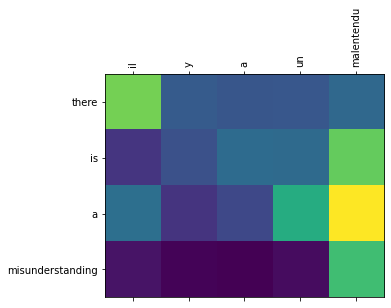

<Figure size 216x216 with 0 Axes>

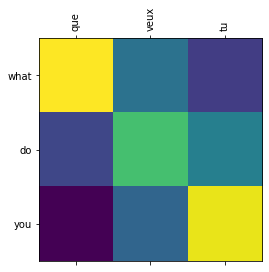

<Figure size 216x288 with 0 Axes>

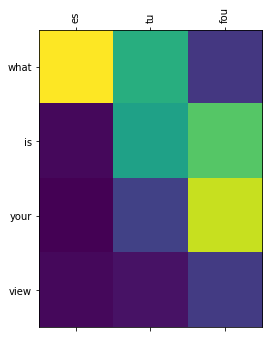

<Figure size 216x144 with 0 Axes>

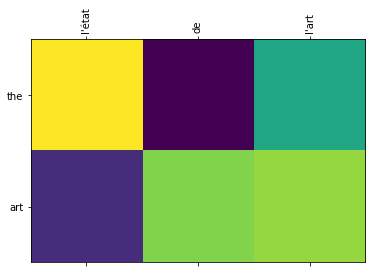

<Figure size 216x288 with 0 Axes>

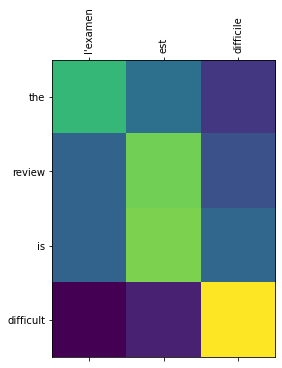

<Figure size 360x504 with 0 Axes>

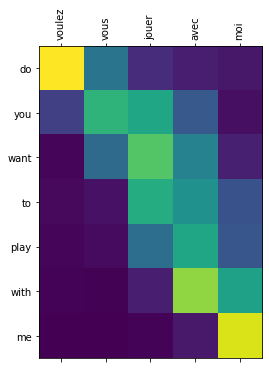

<Figure size 144x72 with 0 Axes>

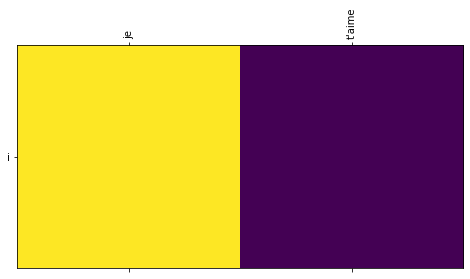

<Figure size 216x216 with 0 Axes>

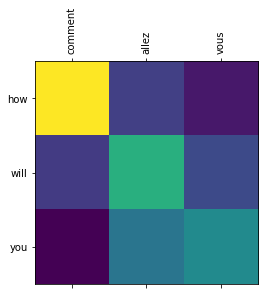

<Figure size 648x648 with 0 Axes>

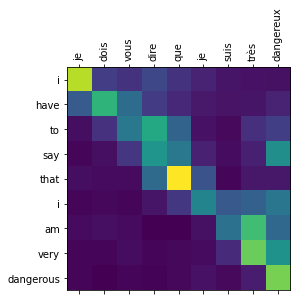

<Figure size 504x576 with 0 Axes>

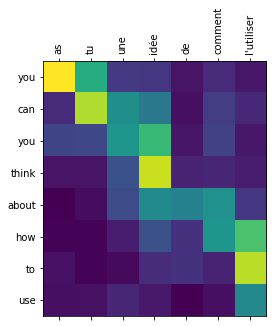

In [18]:
sentences = ["il y a un malentendu",
             'que veux tu',
             'es tu fou',
             "l'état de l'art",
             "l'examen est difficile", 
             'voulez vous jouer avec moi',
             "je t'aime",
             "comment allez vous",
             'je dois vous dire que je suis très dangereux',
             "as tu une idée de comment l'utiliser"]

for inp_sentence in sentences:
    inp_array = inp_sentence.split()
    inp_len = len(inp_sentence.split())
    trans_sentence, attention_weights = translate_sentence(inp_sentence)
    trans_array = trans_sentence.split()
    trans_len = len(trans_array)
    attention_weights = np.array([x for x in attention_weights])
    attention_weights = attention_weights[:trans_len,:inp_len]
    plt.figure(figsize=(inp_len, trans_len))
    plt.matshow(attention_weights)
    plt.xticks(ticks=range(inp_len), labels=inp_array, rotation=90)
    plt.yticks(ticks=range(trans_len), labels=trans_array)
    print('FR : ', inp_sentence)
    print('EN : ', trans_sentence)
    print('-'*30)